In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%pip install torch torchvision torchaudio
%pip install torchtext
%pip install pytorch-lightning-bolts
%pip install datasets
%pip install transformers

     |████████████████████████████████| 252 kB 5.1 MB/s 
     |████████████████████████████████| 584 kB 37.4 MB/s 
     |████████████████████████████████| 409 kB 46.6 MB/s 
     |████████████████████████████████| 596 kB 27.7 MB/s 
     |████████████████████████████████| 136 kB 38.6 MB/s 
     |████████████████████████████████| 1.1 MB 41.9 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 52.3 MB/s 
     |████████████████████████████████| 144 kB 39.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 42.2 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 127 kB 43.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!ls

gdrive	sample_data


In [5]:
%cd "gdrive/MyDrive/CoLLT/"

/content/gdrive/MyDrive/CoLLT


In [6]:
%pwd

'/content/gdrive/MyDrive/CoLLT'

In [7]:
import torch
import os.path as osp
import losses as L
import augmentors as A
import models as M
import torch.nn.functional as F

from tqdm import tqdm
from torch.optim import Adam, AdamW
import datasets
from contrast_models import WithinEmbedContrast
from pl_bolts.optimizers import LinearWarmupCosineAnnealingLR
import numpy as np
device_name = 'cpu'
device = torch.device(device_name)

/usr/local/lib/python3.7/dist-packages/pl_bolts/utils/warnings.py:32: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  f' install it with `pip install {pypi_name}`.' + extra_text


In [8]:
train_data, test_data = datasets.load_dataset('imdb', split =['train', 'test'], 
                                            cache_dir='./data/')

Reusing dataset imdb (./data/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
length_array = []
for data in train_data:
  split_array = data["text"].split(" ")
  length_array.append(len(split_array))

In [13]:
print(length_array)
min_length = min(length_array)
max_length = max(length_array)

[288, 214, 93, 118, 311, 123, 114, 301, 480, 224, 262, 136, 128, 140, 360, 202, 78, 888, 69, 158, 177, 151, 166, 325, 105, 186, 228, 115, 232, 369, 168, 149, 154, 179, 385, 124, 155, 296, 223, 119, 133, 124, 837, 238, 483, 138, 126, 118, 157, 130, 187, 195, 462, 245, 283, 458, 260, 148, 125, 49, 214, 180, 170, 326, 127, 343, 258, 137, 76, 770, 228, 55, 144, 120, 364, 117, 146, 185, 124, 351, 629, 138, 359, 159, 247, 265, 268, 589, 275, 332, 280, 123, 865, 48, 109, 520, 171, 157, 516, 132, 155, 156, 255, 233, 174, 276, 246, 138, 190, 159, 46, 398, 500, 170, 114, 331, 137, 132, 139, 147, 322, 145, 201, 76, 312, 130, 125, 112, 863, 305, 306, 122, 224, 113, 149, 72, 261, 231, 182, 49, 146, 217, 594, 153, 179, 120, 108, 426, 138, 388, 166, 141, 146, 191, 174, 252, 168, 169, 156, 151, 69, 157, 193, 258, 143, 379, 151, 305, 305, 174, 122, 185, 246, 264, 116, 112, 96, 140, 331, 203, 913, 83, 126, 147, 127, 226, 87, 156, 72, 59, 127, 214, 167, 159, 84, 84, 44, 906, 516, 132, 161, 121, 139, 374,

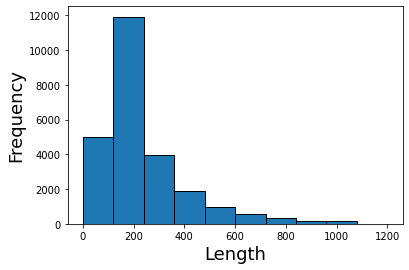

In [67]:
import matplotlib.pyplot as plt
plt.hist(length_array, range=(0,1200),edgecolor='black')
plt.xlabel('Length', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

plt.show()

In [66]:
min_length = min(length_array)
max_length = max(length_array)
print(min_length)
print(max_length)


10
2470


In [34]:
import pickle
with open("data.pickle","rb") as f:
    train_data_dev = pickle.load(f)



In [35]:
train_length_array = []
for data in train_data_dev:
  split_array = data["text"].split(" ")
  train_length_array.append(len(split_array))

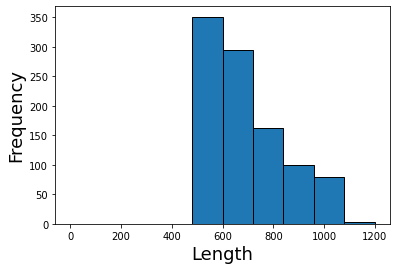

In [68]:
import matplotlib.pyplot as plt
plt.hist(train_length_array, range=(0,1200),edgecolor='black')
plt.xlabel('Length', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
# plt.title('Frequency distribution of text length for training sample')
plt.show()

In [48]:
with open("data_val.pickle","rb") as f:
    test_data_dev = pickle.load(f)


In [49]:
test_length_array = []
for data in test_data_dev:
  split_array = data["text"].split(" ")
  test_length_array.append(len(split_array))
print(len(test_length_array))

600


In [73]:
test_data_dev[1]["text"]

"Here's another Antonioni that will be rediscovered again and again as soon as it comes out on tape or DVD. I saw it a few months ago when it ran for the first time (even in metropolitan movie capital L.A.!)for a couple of weeks and then disappeared (art house audiences seem to have opted for their own special territory, where older favorites like Antonioni and Resnais are only welcome as occasional curiosities).<br /><br />At first I was disappointed, thought the pace to be unbearably boring, and that the man had lost a chance (for years Antonioni had found it difficult to find financing)at an advanced age to add another masterpiece to his canon; but knowing Antonioni for what he was and how I had at first reacted to Blow-Up and the Passenger, I refused to pass judgment until I had seen the film again. I went back the next day and I should not have been surprised that the film kept pulling me in, making me aware of things I had thought about and lost track of throughout my life, drivi

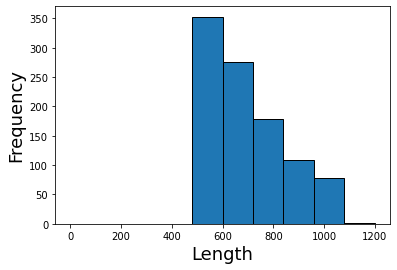

In [69]:
import matplotlib.pyplot as plt
plt.hist(test_length_array, range=(0,1200),edgecolor='black')
plt.xlabel('Length', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
# plt.title('Frequency distribution of text length for validation sample')
plt.show()

In [56]:
with open("data_test.pickle","rb") as f:
    test_data_dev = pickle.load(f)


In [57]:
test_length_array = []
for data in test_data_dev:
  split_array = data["text"].split(" ")
  test_length_array.append(len(split_array))
print(len(test_length_array))

1000


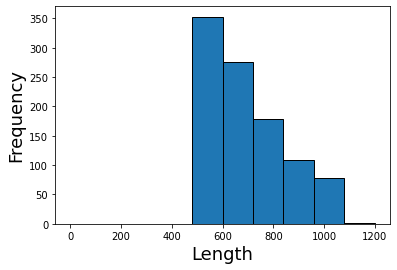

In [70]:
import matplotlib.pyplot as plt
plt.hist(test_length_array, range=(0,1200),edgecolor='black')
plt.xlabel('Length', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
# plt.title('Frequency distribution of text length for test sample')
plt.show()